In [19]:
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
import time

In [20]:
def read_mrc_file(file_path):
    """Reads a volume from an MRC file."""
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)
    try:
        with mrcfile.open(file_path, permissive=True) as mrc:
            volume = mrc.data.astype(np.float32)
            voxel_size = mrc.voxel_size
            if volume.ndim != 3:
                print("Error: Input volume is not 3-dimensional.")
                sys.exit(1)
    except Exception as e:
        print(f"Error reading MRC file: {e}")
        sys.exit(1)
    return volume, voxel_size

# Testing:

1. Rotate and project function

To make the function faster, consider using the following optimizations:

Combine Rotations: Instead of performing three separate rotations, combine the rotation angles into a single transformation matrix and apply it using a single call to a rotation or transformation library.

Optimize Interpolation: The order=1 (linear interpolation) is already faster than higher-order interpolations, but further gains can be achieved by precomputing indices and weights if the rotation angles are fixed or by using more efficient libraries like OpenCV or GPU-accelerated tools.

Leverage GPU Acceleration: Libraries such as CuPy, TensorFlow, or PyTorch can be utilized for GPU acceleration of rotations and projections.

Here is an optimized implementation:

## Rotate Project Optimization


Projection shape: (128, 128)
Time taken to rotate and project : 0.11175942420959473 seconds


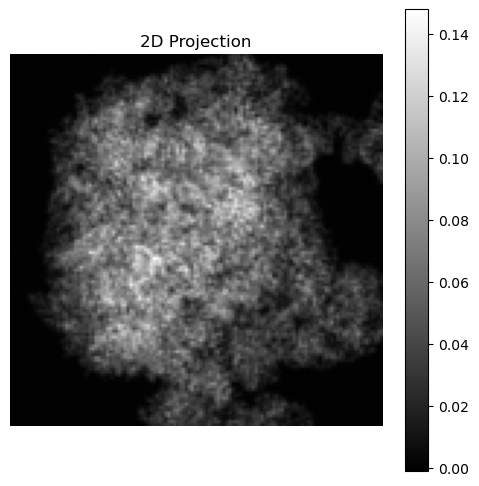

In [27]:
import numpy as np
import os
import mrcfile
import matplotlib.pyplot as plt
import time
from scipy.ndimage import affine_transform

def rotate_and_project_opt(volume, phi, theta, psi):
    """Efficiently rotates the volume and projects it along the Z-axis."""
    # Compute combined rotation matrix
    cos_phi, sin_phi = np.cos(np.radians(phi)), np.sin(np.radians(phi))
    cos_theta, sin_theta = np.cos(np.radians(theta)), np.sin(np.radians(theta))
    cos_psi, sin_psi = np.cos(np.radians(psi)), np.sin(np.radians(psi))

    # Rotation matrices for each axis
    R_phi = np.array([
        [cos_phi, -sin_phi, 0],
        [sin_phi, cos_phi, 0],
        [0, 0, 1]
    ])

    R_theta = np.array([
        [cos_theta, 0, sin_theta],
        [0, 1, 0],
        [-sin_theta, 0, cos_theta]
    ])

    R_psi = np.array([
        [cos_psi, -sin_psi, 0],
        [sin_psi, cos_psi, 0],
        [0, 0, 1]
    ])

    # Combined rotation matrix
    R = R_psi @ R_theta @ R_phi

    # Center the volume for rotation
    center = np.array(volume.shape) / 2
    offset = center - R @ center

    # Apply affine transformation (rotation)
    rotated = affine_transform(volume, R, offset=offset, order=1)

    # Project along Z-axis
    projection = np.sum(rotated, axis=0)

    return projection

def read_mrc_file(file_path):
    """Reads a volume from an MRC file."""
    if not os.path.isfile(file_path):
        print(f"Error: File '{file_path}' not found.")
        sys.exit(1)
    try:
        with mrcfile.open(file_path, permissive=True) as mrc:
            volume = mrc.data.astype(np.float32)
            voxel_size = mrc.voxel_size
            if volume.ndim != 3:
                print("Error: Input volume is not 3-dimensional.")
                sys.exit(1)
    except Exception as e:
        print(f"Error reading MRC file: {e}")
        sys.exit(1)
    return volume, voxel_size

# Example usage
volume_file = '0_data/7ood.mrc'
volume, voxel_size = read_mrc_file(volume_file)
phi, theta, psi = 45, 30, 60
projection = np.zeros((volume.shape[1], volume.shape[2]), dtype=float)
#print("Projection shape:", projection.shape)
start_time = time.time()
projection = rotate_and_project_opt(volume, phi, theta, psi)
end_time = time.time()
print("Projection shape:", projection.shape)
print(f"Time taken to rotate and project : {end_time-start_time} seconds")
plt.figure(figsize=(6, 6))
plt.imshow(projection, cmap='gray')
plt.title('2D Projection')
plt.axis('off')
plt.colorbar()
plt.show()



## Key Improvements
1. Single Transformation: Combining the rotation matrices into one reduces computational overhead.
2. Affine Transformation: scipy.ndimage.affine_transform is efficient for applying a combined transformation.
3. Precomputed Offsets: Adjusting for the center avoids unnecessary recalculations.

This approach minimizes the number of transformations and uses efficient matrix operations, significantly improving the performance. If further speedup is needed, consider using GPU-accelerated libraries.

# GPU kernel call

# Parallel